#Importing Libraries

In [18]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from torch import nn
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Loading Data

In [19]:
data = load_wine()
X, y = data.data, data.target
y_df = pd.DataFrame(y)
X_df = pd.DataFrame(X)

#Experimenting

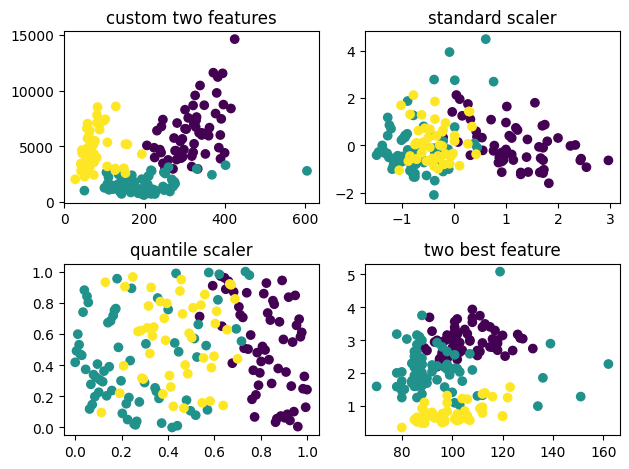

In [20]:
pca = PCA(n_components=2)
standard = StandardScaler()
quantile = QuantileTransformer(n_quantiles=len(X_df))
selector = SelectKBest(k = 4, score_func=chi2)
x_pca_transformed = pd.DataFrame(pca.fit_transform(X_df))
x_normal_transformed = pd.DataFrame(standard.fit_transform(x_pca_transformed))
x_Quantile_transformed = pd.DataFrame(quantile.fit_transform(x_pca_transformed))
c = selector.fit_transform(X_df, y_df.squeeze())
four_best_features = pd.DataFrame(selector.fit_transform(X_df, y_df), columns=["feature 1", "feature 2", "feature 3", "feature 4"])
custom_feature_1 = four_best_features.loc[:, "feature 1"] * ((four_best_features.loc[:, "feature 2"].to_numpy()))
custom_feature_2 = four_best_features.loc[:, "feature 3"] * (four_best_features.loc[:, "feature 4"])
fig , axs = plt.subplots(2, 2)
axs[0, 0].set_title("custom two features")
axs[0, 1].set_title("standard scaler")
axs[1, 0].set_title('quantile scaler')
axs[1, 1].set_title('two best feature')
axs[0, 0].scatter(custom_feature_1, custom_feature_2 ,c=y);
axs[0, 1].scatter(x_normal_transformed.iloc[:, 0], x_normal_transformed.iloc[:, 1], c=y);
axs[1, 0].scatter(x_Quantile_transformed.iloc[:, 0], x_Quantile_transformed.iloc[:, 1], c=y);
axs[1 ,1].scatter(four_best_features.loc[:, "feature 1"], four_best_features.loc[:, "feature 2"], c=y_df)
plt.tight_layout()

#Feature Engineering

In [21]:
X_df[13] = custom_feature_1
X_df[14] = custom_feature_2

#Transforming & Spliting

In [22]:
X_df = standard.fit_transform(X_df)
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.15 , stratify=y_df,shuffle=True, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().squeeze(), dtype=torch.int64)
y_test = torch.tensor(y_test.to_numpy().squeeze(), dtype=torch.int64)

#Building

In [23]:
class NetWork(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(15, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 3)
    )
  def forward(self, x):
    return self.network(x)

#Training

In [28]:
list_of_test_losses = []
list_of_train_losses = []
iter = 501
model = NetWork()
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay = 1e-4)
for i in range(iter):
  model.train()
  y_pred_train = model(x_train)
  train_loss = loss_func(y_pred_train, y_train)
  opt.zero_grad()
  train_loss.backward()
  opt.step()
  model.eval()
  with torch.inference_mode():
      y_pred_test = model(x_test)
      test_loss = loss_func(y_pred_test, y_test)
      list_of_test_losses.append(test_loss)
      list_of_train_losses.append(train_loss)
      y_prob_train = F.softmax(y_pred_train, dim=1)
      y_prob_test = F.softmax(y_pred_test, dim=1)
      y_labels_train = torch.argmax(y_prob_train, dim = 1)
      y_labels_test = torch.argmax(y_prob_test, dim =1)
      correct_test = (y_labels_test == y_test).sum()
      correct_train = (y_labels_train == y_train).sum()
      if i % 100 ==0:
        print(f"train loss: {train_loss} \t test loss: {test_loss}")
        print(f"accuracy test: {correct_test / len(y_test)}")
        print(f"accuracy train: {correct_train / len(y_train)}")
with torch.inference_mode():
  y_pred_test = model(x_test)
  y_prob_test = F.softmax(y_pred_test, dim=1)
  list_of_y_pred_test = torch.argmax(y_prob_test, dim = 1)
accuracy_score(y_test,list_of_y_pred_test)

train loss: 1.1197758913040161 	 test loss: 0.9101530909538269
accuracy test: 0.8518518805503845
accuracy train: 0.33112582564353943
train loss: 9.876318472379353e-06 	 test loss: 0.0014154397649690509
accuracy test: 1.0
accuracy train: 1.0
train loss: 3.073862171731889e-05 	 test loss: 0.002743595978245139
accuracy test: 1.0
accuracy train: 1.0
train loss: 7.289200584637001e-05 	 test loss: 0.004325380548834801
accuracy test: 1.0
accuracy train: 1.0
train loss: 0.00010073311568703502 	 test loss: 0.008860321715474129
accuracy test: 1.0
accuracy train: 1.0
train loss: 0.00012113322009099647 	 test loss: 0.016126202419400215
accuracy test: 1.0
accuracy train: 1.0


1.0

#Ploting Loss

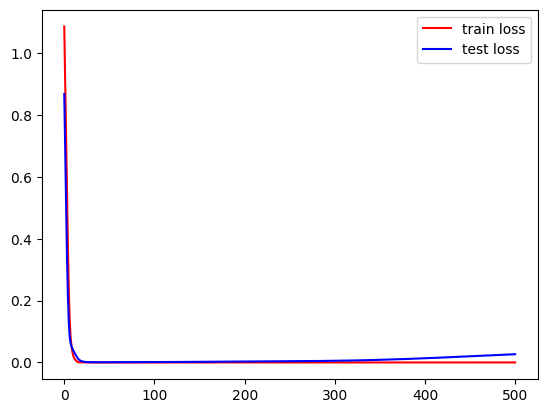

In [25]:
plt.plot(range(len(list_of_train_losses)), [i.detach() for i in list_of_train_losses], label="train loss", c="r")
plt.plot(range(len(list_of_test_losses)), list_of_test_losses, label="test loss", c="b")
plt.legend()

#Saving

In [41]:
torch.save(model, "/content/sample_data/wine_classifier.pth")
torch.save(model.state_dict(), "/content/sample_data/wine_classifier_state_dict.pth")

#Loading

In [45]:
loaded_model_state_dict = NetWork()
loaded_model_state_dict.load_state_dict(torch.load("/content/sample_data/wine_classifier_state_dict.pth", weights_only=False))
loaded_model = torch.load("/content/sample_data/wine_classifier.pth", weights_only=False)

(NetWork(
   (network): Sequential(
     (0): Linear(in_features=15, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=3, bias=True)
   )
 ),
 NetWork(
   (network): Sequential(
     (0): Linear(in_features=15, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=3, bias=True)
   )
 ))